# Laboratory work 2

## Some preparation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import re

import pandas as pd

from IPython.display import display 

from PIL import Image
import wave

## Task 1

- виконує вбудовування водяного знаку зображення. 

- Для процесу вбудовування водяний знак перетворити до бінарного (чорно-білого, не сірого!). 


- Використати для вбудовування метод найменшого значущого біта. 
- Параметр «номер бітової площини» (натуральне число, менше за 9)
- вивести на форму головного вікна для відображення різниці в
результатах вбудовування. 
- Водяний знак вбудовувати у канал Blue.
- Передбачити випадок різних розмірів вхідного зображення
(контейнера) та водяного знаку.
- Якщо вхідне зображення більше за
водяний знак, виконати вбудовування циклічно та періодично для
всього вхідного зображення (замостити вхідне зображення водяним
знаком). 
- Якщо вхідне зображення менше за водяний знак, вбудувати
частину водяного знаку для всього вхідного зображення.



- Здійснити вбудовування текстової інформації (яка представлена
побітово) у вхідне зображення на основі методу найменшого
значущого біта.
- - Написати також метод, який виконує вилучення вонядного знаку із
заповненого конейнега (зображення з водяним знаком).

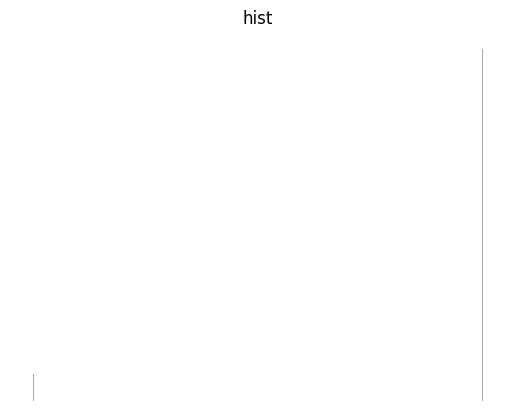

0 255
0 1


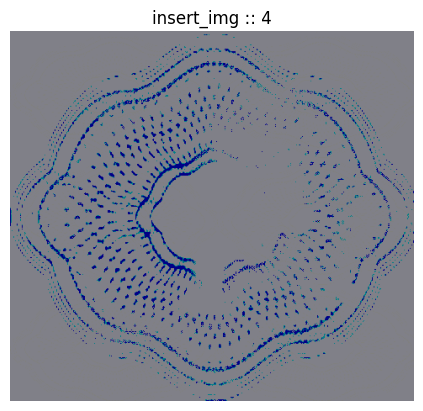

,Function,Time
0,first,0.000516
1,second,0.000184
2,third,0.075420


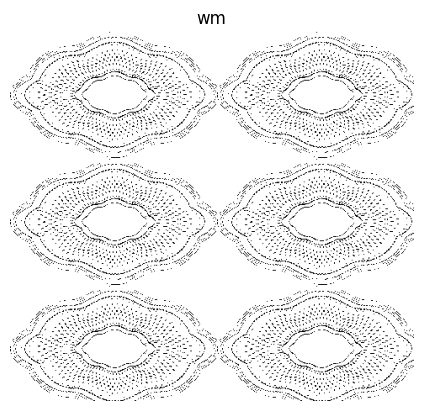

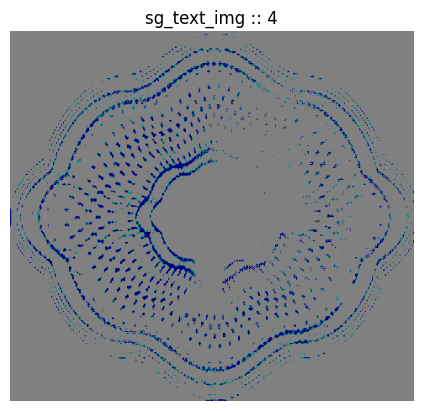

,Function,result,Time
0,first,lissa,0.000008
1,second,lissa,0.000074


'lissa'

In [2]:
class Steganography:
    def __init__(self, img_png, wm_png):
        self.img = cv2.imread(img_png).astype(np.uint8)
        self.wm = cv2.imread(wm_png, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

        self.white_black()
        self.resize()

    def white_black(self):
        arr = np.array(self.wm)
        self.wm = np.where(arr > 127, 255, 0).astype(np.uint8)
        # self.wm = Image.fromarray(binaty)

    def resize(self):
        img_height, img_width, _ = self.img.shape
        wm_height, wm_width = self.wm.shape
        result = np.zeros((img_height, img_width), dtype=np.uint8)

        for i in range(img_height):
            for j in range(img_width):
                result[i, j] = self.wm[i % wm_height, j % wm_width]
        self.wm = result

        min = np.min(self.wm)
        max = np.max(self.wm)

        plt.title('hist')
        plt.hist(self.wm.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
        plt.axis('off')
        plt.show()

        print(min, max)

        self.wm = (self.wm // 255).astype(np.uint8)

        min = np.min(self.wm)
        max = np.max(self.wm)
        print(min, max)

    def insert(self, bit):

        picture = self.img[:, :, 0].copy()
        picture_r = self.img.copy()
        mask = 1 << (bit - 1)

        picture = np.bitwise_and(picture, 255 - mask)
        picture = np.bitwise_or(picture, self.wm * mask)

        picture_r[:, :, 0] = picture.astype(np.uint8)
        self.picture_r = picture_r

        return picture_r
    

    def extract_wm(self, bit):

        picture = self.picture_r[:, :, 0]
        mask = 1 << (bit - 1)

        taimi = []
        
        start_time = time.time()
        result = (picture & mask) >> (bit - 1)
        result = (result * 255).astype(np.uint8)
        end_time = time.time()

        taimi.append(('first', end_time - start_time))

        start_time = time.time()
        result_1 = (picture & mask) // mask * 255
        end_time = time.time()

        taimi.append(('second', end_time - start_time))

        start_time = time.time()
        result_2 = np.zeros_like(picture)

        for i in range(picture.shape[0]): 
            for j in range(picture.shape[1]):  
                if (picture[i, j] & mask) > 0:
                    result_2[i, j] = 255  
                else:
                    result_2[i, j] = 0 
        end_time = time.time()

        taimi.append(("third", end_time -  start_time))

        df = pd.DataFrame(taimi, columns=['Function', 'Time'])
        df_table = df.style.background_gradient(subset=["Time"], cmap="RdYlGn_r", vmin=0, vmax=0.01)

    
        display(df_table)

        plt.title(f"wm")
        plt.imshow(result_2, cmap='gray')
        plt.axis('off')
        plt.show()


    def text_to_binary(self, text):
        result = ''

        for i in text:
            code = ord(i)
            bin_r = bin(code)[2:].zfill(8)
            result += bin_r

        return result


    def text_input(self, code):
        text = []

        result = []

        start_time = time.time()

        for i in range(0, len(code), 8):
            byte = code[i:i+8]
            if not byte:
                break

            text.append(chr(int(byte, 2)))

        result_1 = ''.join(text)
        end_time = time.time()

        result.append(('first', result_1, end_time - start_time))

        start_time = time.time()
        res_2 = re.findall('.{8}', code)
        result_2 = ""

        for i in res_2:
            char = chr(int(i, 2))
            result_2 += char
        end_time = time.time()

        result.append(('second', result_2, end_time - start_time))
        df = pd.DataFrame(result, columns=['Function', 'result', 'Time'])
        df_table = df.style.background_gradient(subset=["Time"], cmap="RdYlGn_r", vmin=0, vmax=0.01)
        display(df_table)
        
        return  df_table, result_1

    def insert_text(self, text, bit):
        
        picture = self.img.copy()
        

        bin_text = self.text_to_binary(text)
        
        if len(bin_text) > picture.size:
            raise ValueError("a lot of")
        mask = np.uint8(1 << (bit - 1))
        check = 0
        
        for i in range(picture.shape[0]):
            for j in range(picture.shape[1]):

                if check >= len(bin_text):
                    break
                a = np.uint8(picture[i, j,0] & ~mask) | np.uint8(int(bin_text[check]) * mask)
                picture[i, j, 0] = np.clip(a, 0, 255).astype(np.uint8)
                
                check += 1

        self.img_text = picture
        
        return picture

    def extract_text(self, bit, length):
        picture = self.img_text[:, :, 0]

        res_text = ""

        mask = np.uint8(1 << (bit - 1))
        
        for i in range(picture.shape[0]):
            for j in range(picture.shape[1]):
               
                if length is not None and len(res_text) >= length:
                    break
            
                bit_value = (picture[i, j] & mask) >> (bit - 1)
                res_text += str(bit_value)
        
        _, text = self.text_input(res_text)
    
        return text

    def show_image(self, img, bit, title):
        plt.title(f"{title} :: {bit}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

wm = "WM.png"
img =  "extracted_image.png"

bit = 4
sg = Steganography(img, wm)
insert = sg.insert(bit=bit)
sg.show_image(img= insert, bit=bit, title="insert_img")

df = sg.extract_wm(bit=bit)

# r = sg.text_to_binary(text='lissa')
# r
sg_text_img = sg.insert_text(text='lissa', bit=bit)
sg.show_image(img= sg_text_img, bit=bit, title="sg_text_img")

extracted_text = sg.extract_text(bit, 40)
extracted_text

In [3]:

res = sg.text_input(code = '0110110001101001011100110111001101100001')

res


,Function,result,Time
0,first,lissa,0.000011
1,second,lissa,0.000015


(<pandas.io.formats.style.Styler at 0x110b6dd10>, 'lissa')

## Taks 2

In [4]:
def gif_in(gif_path, wm_path, bit):

    gif = Image.open(gif_path)
    frames = []
    wm = Image.open(wm_path).convert("RGB")

    
    wm = wm.resize((gif.size[0], gif.size[1])) 
    array = np.array(wm)

    for frame in range(gif.n_frames):
        gif.seek(frame)
        frame_image = gif.copy().convert("RGB")
        frame_array = np.array(frame_image)

        mask = ~(1 << (bit - 1)) & 0xFF  

        for channel in range(3):  
            frame_array[:, :, channel] &= mask  
            frame_array[:, :, channel] |= ((array[:, :, channel] >> (8 - bit)) & 1) << (bit - 1)

        frames.append(Image.fromarray(frame_array))

    frames[0].save('giphyyyy.gif', save_all=True, append_images=frames[1:], loop=0, duration=gif.info['duration'])

bit = 7
gif_in('giphy.gif', 'WM.png', bit)

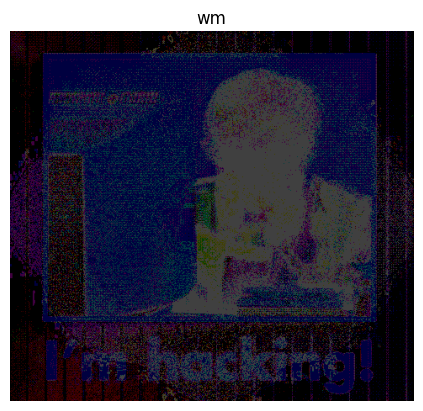

In [5]:
def gif_on(gif_path, bit):

    gif = Image.open(gif_path)
    result = None

    for frame in range(gif.n_frames):
        gif.seek(frame)
        frame_image = gif.copy().convert("RGB")
        frame_array = np.array(frame_image)

        if result is None:
            result = np.zeros_like(frame_array)
        for channel in range(3): 
            result[:, :, channel] |= ((frame_array[:, :, channel] >> (bit - 1)) & 1) << (8 - bit)

    result = Image.fromarray(result.astype(np.uint8))
    plt.title(f"wm")
    plt.imshow(result, cmap='gray')
    plt.axis('off')
    plt.show()

bit=2
gif_on('giphyyyy.gif', bit)

## Task 3


In [6]:
def task_3(image_path, audio_path, music_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    pixels = np.array(img)

    audio = wave.open(audio_path, 'rb')
    music = audio.readframes(audio.getnframes())
    bits = ''.join(format(byte, '08b') for byte in music)

    index = 0
    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            for k in range(3): 
                if index < len(bits):
                    pixels[i, j, k] = (pixels[i, j, k] & 0xFE) | int(bits[index])
                    index += 1
                else:
                    break

    img_with_audio = Image.fromarray(pixels)
    img_with_audio.save(music_path)


In [ ]:

def extr_task3(image_path, saving):
    img = Image.open(image_path)
    img = img.convert('RGB')
    pixels = np.array(img)
    bits = []


    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            for k in range(3): 

                bits.append(str(pixels[i, j, k] & 1))

    audio_bytes = []
    for i in range(0, len(bits), 8):
        byte_bits = ''.join(bits[i:i+8])
        audio_bytes.append(int(byte_bits, 2))

    with wave.open(saving, 'wb') as audio:
        audio.setnchannels(1)
        audio.setsampwidth(2)
        audio.setframerate(44100)
        audio.writeframes(bytes(audio_bytes))

task_3('InputImage.png', 'notification-22-270130.wav', 'RESmusic.png')
extr_task3('img_audio.png', 'audio_res.wav')